In [38]:
from multivp_dataset import MULTI_VP_Dataset
from pathlib import Path
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

from sklearn.preprocessing import StandardScaler, MinMaxScaler
import numpy as np
from tqdm.notebook import tqdm
import datetime

from models.mad_gan import Generator, Discriminator
from tools.viz import plot_anomalies, plot_single_var, plot_to_tensorboard, plot_anomaly_scores, plot_train_hist
from tools.anomaly import madgan_reconstruction, madgan_reconstruction_discr_loss, feature_anomaly_score

time_id = datetime.datetime.now().strftime("%m%d-%H%M")

class Options:
    def __init__(self):
        # Dataset
        self.data_path = Path('../data/compiled/inputs.csv')
        self.batch_size = 32
        self.nworkers = 4
        self.shuffle = True
        self.drop_last = False
        self.method = "window_mag"
        self.nseqs = 4
        self.scaler = MinMaxScaler((-1,1))
        self.wsize = 5
        
        # Train params
        self.lr = 0.0001
        self.epochs = 25
        self.G_niters = 5
        self.D_niters = 10
        
        self.model_out = Path('./runs/multi/' + time_id + '_w20_madgan_pca320')
        self.train_plots = True

        # create ouput dirs
        if not self.model_out.exists(): self.model_out.mkdir(parents=True)
        
        (self.model_out / "img").mkdir(exist_ok=True)
        
opts = Options()


# Setup Training Dataset

In [39]:
dataset = MULTI_VP_Dataset(
    path=opts.data_path,
    method=opts.method,
    remove_extreme=True,
    is_train=True,
    scaler=opts.scaler,
    # nseqs=opts.nseqs
    window_size=opts.wsize,
    use_pca=True,
    pca_scaler=MinMaxScaler((-1,1)),
    n_components=128   
)
dataloader = DataLoader(dataset, batch_size=opts.batch_size, shuffle=True, num_workers=opts.nworkers, drop_last=False)

Removed 705 extreme values
Window size: 5
Window shape:  torch.Size([5, 128])
First window:
 tensor([[ 3.2176e-01, -4.2663e-01,  2.2099e-01, -2.5098e-02, -4.2099e-02,
         -6.6451e-01, -1.6003e-01, -5.0534e-01, -2.4341e-01, -1.5236e-01,
         -3.9254e-01, -2.1491e-01, -8.5607e-02, -5.3411e-02, -7.6194e-02,
         -2.3526e-01, -1.8713e-01, -3.2546e-02, -2.3555e-01, -7.0367e-01,
         -3.3448e-01, -5.7108e-02, -5.6203e-02, -1.7620e-01, -1.4149e-01,
         -4.9773e-02, -1.4797e-01, -2.2705e-01, -5.4293e-02, -2.4061e-01,
         -1.1997e-01, -1.7336e-01, -1.1563e-01, -1.2490e-01, -1.6875e-01,
         -4.3222e-01, -1.5218e-01, -1.9765e-01, -2.7059e-02, -3.7355e-01,
         -3.5790e-02, -6.6057e-03, -1.1522e-01, -1.1569e-01, -1.6973e-01,
         -7.0116e-02, -5.1677e-01, -1.0257e-01, -3.5205e-02, -1.9462e-01,
         -2.9690e-02, -5.6946e-02, -1.9391e-01, -2.8817e-01, -8.5916e-02,
         -3.9203e-01, -1.0368e-01, -3.0914e-03, -7.0158e-02, -2.9515e-01,
         -3.8952e-0

In [40]:
# dataset.plot(title="Magnetic Field")

# Models

In [41]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: ", device)

netG = Generator(
    input_size=dataset.inputs.shape[1],
    hidden_size=100,
    output_size=dataset.inputs.shape[1],
    nlayers=3,
    dropout=0,
    bidirectional=False,
    arch='GRU',
).to(device)

netD = Discriminator(
    input_size=dataset.inputs.shape[1],
    hidden_size=100,
    nlayers=1,
    dropout=0.1,
    bidirectional=False,
    arch='GRU',
).to(device)

Using device:  cuda:0


/home/admin/.local/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [42]:
netG.train()

Generator(
  (rnn): GRU(128, 100, num_layers=3, batch_first=True)
  (linear): Linear(in_features=100, out_features=128, bias=True)
)

In [43]:
netD.train()

Discriminator(
  (rnn): GRU(128, 100, batch_first=True, dropout=0.1)
  (linear): Linear(in_features=100, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [44]:
logger = SummaryWriter(f"logs/mad_gan_pca/{time_id}_D{netD.hidden_size}-L{netD.nlayers}_G{netG.hidden_size}-L{netG.nlayers}")
logger.add_graph(netG, torch.randn(opts.batch_size, opts.wsize, dataset.inputs.shape[1]).to(device))
logger.add_graph(netD, torch.randn(opts.batch_size,opts.wsize, dataset.inputs.shape[1]).to(device))
logger.add_text("Generator", netG.__str__())
logger.add_text("Discriminator", netD.__str__())

# Training

In [45]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

nseqs = opts.wsize

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=opts.lr)
optimizerG = optim.Adam(netG.parameters(), lr=opts.lr)

In [46]:
# Training Loop

# Lists to keep track of progress
G_losses = []
D_losses = []
iters = 0
best_loss = np.inf
best_loss_dist = np.inf

print("Starting Training Loop...")
# For each epoch
for epoch in range(opts.epochs):
    D_epoch_loss = 0
    G_epoch_loss = 0
    
    # For each batch in the dataloader
    for i, (x, _filename) in tqdm(enumerate(dataloader), desc=f"Epoch [{epoch}/{opts.epochs}]", total=len(dataloader), leave=False):
        
        # Format batch
        real = x.to(device)
        b_size, seq_len = real.size(0), real.size(1)
        real_labels = torch.full((b_size, nseqs, 1), real_label, dtype=torch.float, device=device)
        
        # Train discriminator network to maximize log(D(x)) + log(1 - D(G(z)))
        for _ in range(opts.D_niters):
            netD.zero_grad()
            
            # Train with real batch
            output = netD(real)
            errD_real = criterion(output, real_labels)
            errD_real.backward()
            
            # Train with fake batch
            fake = netG(torch.randn_like(real, device=device))
            fake_labels = torch.full((b_size, nseqs, 1), fake_label, dtype=torch.float, device=device)
            
            output = netD(fake.detach())
            errD_fake = criterion(output, fake_labels)
            errD_fake.backward()
            
            errD = errD_real + errD_fake
            optimizerD.step()
        D_losses.append(errD.item())
        
        # Train generator network to maximize log(D(G(z)))
        for _ in range(opts.G_niters):
            netG.zero_grad()
            
            fake = netG(torch.randn_like(real, device=device))
            output = netD(fake)
            errG = criterion(output, real_labels)
            errG.backward()
            optimizerG.step()
        G_losses.append(errG.item())
        # send losses to tensorboard
        logger.add_scalars('Loss/train', {'G': errG.item(), 'D': errD.item()}, iters)
        iters += 1
        
    # Calculate epoch losses
    output = netD(real)
    errD_real = criterion(output, real_labels)
    D_x = output.mean().item()
    
    fake = netG(torch.randn_like(real, device=device)).detach()
    output = netD(fake)
    errD_fake = criterion(output, fake_labels)
    D_G_z1 = output.mean().item()
    
    errD = errD_real + errD_fake
    errG = criterion(output, real_labels)

    # Output training stats
    print('[%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f'
            % (epoch, opts.epochs,
                errD.item(), errG.item(), D_x, D_G_z1))

    # save best model if total loss is better than last 
    # and distance between losses is better than last (model convergence)
    if abs(errD-errG).item() < best_loss_dist and epoch > 2 and D_x > 0.7: 
        best_loss_dist = torch.abs(errD-errG).item()
        torch.save(netG.state_dict(), opts.model_out / 'Gbest.pth')
        torch.save(netD.state_dict(), opts.model_out / 'Dbest.pth')
        
        if opts.train_plots:
            # fake = dataset.unscale(fake.detach().cpu().numpy())
            fake = dataset.flatten(fake.detach().cpu().numpy())
            fig = plot_single_var(fake, 
                            title=f"Epoch {epoch} - G loss: {errG.item():.4f} - D loss: {errD.item():.4f} - Loss diff: {best_loss_dist:.4f}",
                            dpi=200, scale="linear")
            fig.savefig(opts.model_out / f"img/{epoch}_best", dpi=200)
            plot_to_tensorboard(logger, fig, epoch, "train/best")
            plt.close(fig)
    elif epoch % 5 == 0:
        torch.save(netG.state_dict(), opts.model_out / f'G{epoch}.pth')
        torch.save(netD.state_dict(), opts.model_out / f'D{epoch}.pth')
        
        if opts.train_plots:
            fake = dataset.flatten(fake.detach().cpu().numpy())
            # fake = dataset.unscale(fake.detach().cpu().numpy())
            fig = plot_single_var(fake, 
                            title=f"Epoch {epoch} - G loss: {errG.item():.4f} - D loss: {errD.item():.4f} - Loss diff: {best_loss_dist:.4f}",
                            dpi=200, scale="linear")
            fig.savefig(opts.model_out / f'img/inter_{epoch}.png', dpi=200)
            plot_to_tensorboard(logger, fig, epoch, "train/inter")
            plt.close(fig)
            
        train_f = plot_train_hist(D_losses, G_losses, opts.model_out)
        plt.close(train_f)
    

Starting Training Loop...


Epoch [0/25]:   0%|          | 0/346 [00:00<?, ?it/s]

[0/25]	Loss_D: 0.3107	Loss_G: 2.9565	D(x): 0.9693	D(G(z)): 0.1832


Epoch [1/25]:   0%|          | 0/346 [00:00<?, ?it/s]

[1/25]	Loss_D: 0.7079	Loss_G: 2.0350	D(x): 0.8014	D(G(z)): 0.3168


Epoch [2/25]:   0%|          | 0/346 [00:00<?, ?it/s]

[2/25]	Loss_D: 1.2750	Loss_G: 1.1281	D(x): 0.6833	D(G(z)): 0.4724


Epoch [3/25]:   0%|          | 0/346 [00:00<?, ?it/s]

[3/25]	Loss_D: 1.2485	Loss_G: 0.9322	D(x): 0.6987	D(G(z)): 0.4959


Epoch [4/25]:   0%|          | 0/346 [00:00<?, ?it/s]

[4/25]	Loss_D: 1.3684	Loss_G: 0.6339	D(x): 0.6585	D(G(z)): 0.5635


Epoch [5/25]:   0%|          | 0/346 [00:00<?, ?it/s]

[5/25]	Loss_D: 2.1924	Loss_G: 0.3304	D(x): 0.5865	D(G(z)): 0.7377


Epoch [6/25]:   0%|          | 0/346 [00:00<?, ?it/s]

[6/25]	Loss_D: 1.3553	Loss_G: 0.5586	D(x): 0.6475	D(G(z)): 0.5804


Epoch [7/25]:   0%|          | 0/346 [00:00<?, ?it/s]

[7/25]	Loss_D: 1.3979	Loss_G: 0.6304	D(x): 0.6201	D(G(z)): 0.5475


Epoch [8/25]:   0%|          | 0/346 [00:00<?, ?it/s]

[8/25]	Loss_D: 1.7577	Loss_G: 0.4293	D(x): 0.5374	D(G(z)): 0.6558


Epoch [9/25]:   0%|          | 0/346 [00:00<?, ?it/s]

[9/25]	Loss_D: 1.3591	Loss_G: 0.6904	D(x): 0.5927	D(G(z)): 0.5140


Epoch [10/25]:   0%|          | 0/346 [00:00<?, ?it/s]

[10/25]	Loss_D: 1.3682	Loss_G: 0.5761	D(x): 0.6472	D(G(z)): 0.5694


Epoch [11/25]:   0%|          | 0/346 [00:00<?, ?it/s]

[11/25]	Loss_D: 1.4158	Loss_G: 0.6351	D(x): 0.6184	D(G(z)): 0.5363


Epoch [12/25]:   0%|          | 0/346 [00:00<?, ?it/s]

[12/25]	Loss_D: 1.2304	Loss_G: 0.6282	D(x): 0.6486	D(G(z)): 0.5378


Epoch [13/25]:   0%|          | 0/346 [00:00<?, ?it/s]

[13/25]	Loss_D: 1.2447	Loss_G: 0.7226	D(x): 0.6131	D(G(z)): 0.4939


Epoch [14/25]:   0%|          | 0/346 [00:00<?, ?it/s]

[14/25]	Loss_D: 1.4647	Loss_G: 0.5907	D(x): 0.5695	D(G(z)): 0.5678


Epoch [15/25]:   0%|          | 0/346 [00:00<?, ?it/s]

[15/25]	Loss_D: 1.5530	Loss_G: 0.6141	D(x): 0.5596	D(G(z)): 0.5484


Epoch [16/25]:   0%|          | 0/346 [00:00<?, ?it/s]

[16/25]	Loss_D: 1.2746	Loss_G: 0.6528	D(x): 0.6294	D(G(z)): 0.5284


Epoch [17/25]:   0%|          | 0/346 [00:00<?, ?it/s]

[17/25]	Loss_D: 1.4796	Loss_G: 0.5730	D(x): 0.5432	D(G(z)): 0.5696


Epoch [18/25]:   0%|          | 0/346 [00:00<?, ?it/s]

[18/25]	Loss_D: 1.5210	Loss_G: 0.5518	D(x): 0.5576	D(G(z)): 0.5805


Epoch [19/25]:   0%|          | 0/346 [00:00<?, ?it/s]

[19/25]	Loss_D: 1.9019	Loss_G: 0.4424	D(x): 0.4740	D(G(z)): 0.6511


Epoch [20/25]:   0%|          | 0/346 [00:00<?, ?it/s]

[20/25]	Loss_D: 1.8301	Loss_G: 0.4795	D(x): 0.4925	D(G(z)): 0.6339


Epoch [21/25]:   0%|          | 0/346 [00:00<?, ?it/s]

[21/25]	Loss_D: 1.3855	Loss_G: 0.6966	D(x): 0.5755	D(G(z)): 0.5046


Epoch [22/25]:   0%|          | 0/346 [00:00<?, ?it/s]

[22/25]	Loss_D: 1.4030	Loss_G: 0.6637	D(x): 0.5799	D(G(z)): 0.5267


Epoch [23/25]:   0%|          | 0/346 [00:00<?, ?it/s]

[23/25]	Loss_D: 1.4543	Loss_G: 0.5930	D(x): 0.5543	D(G(z)): 0.5552


Epoch [24/25]:   0%|          | 0/346 [00:00<?, ?it/s]

[24/25]	Loss_D: 1.2573	Loss_G: 0.7340	D(x): 0.5851	D(G(z)): 0.4861


In [47]:
logger.flush()

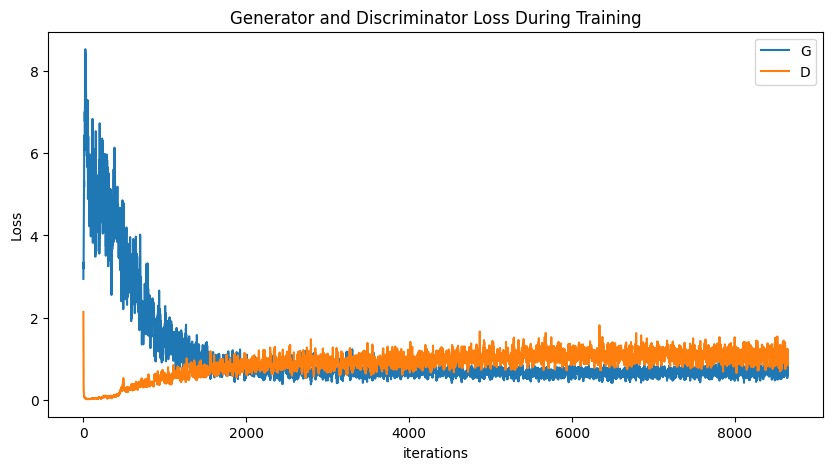

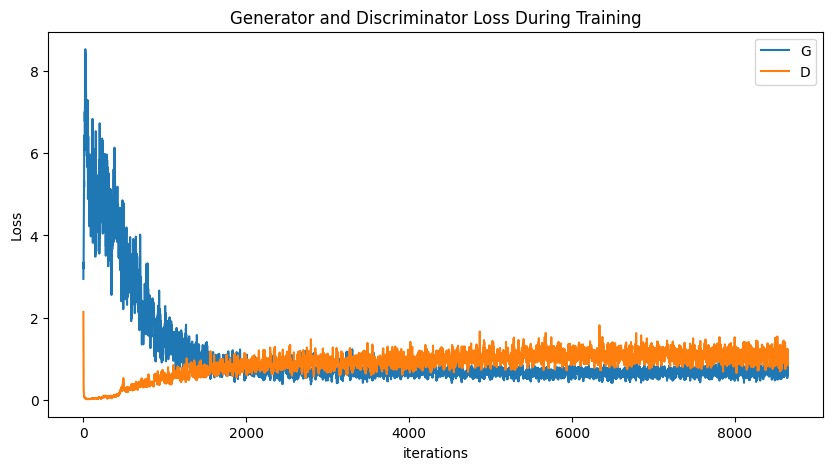

In [48]:
plot_train_hist(D_losses, G_losses, opts.model_out)

# Plot Random Generated Inputs

In [49]:
# # load best model
# netG.load_state_dict(torch.load(opts.model_out / 'G.pth'))

In [50]:
# lines = []

# # generate random samples
# for i in range(100):
#     noise = torch.randn_like(real, device=device)
#     fake, _ = netG(noise)
#     fake = fake.flatten(end_dim=1).detach().cpu().numpy()
#     lines.append(fake)


# inv_fake_data = dataset.unscale(np.array(lines))
# # inv_fake_data = pd.DataFrame(inv_fake_data)

In [51]:
# plot_data_values(inv_fake_data, "Random Generated", label="B [G]", scale="log")

# Anomaly Detection

In [53]:

netD.train(True)
netG.train(True)

class AnomalyParams:
    batch_size = 128
    models_dir = opts.model_out
    # models_dir = Path("./runs/multi/0313-1135_w20_madgan_pca320")
    # reconstruction based
    niter = 100 # number of iterations for reconstruction
    lambda_thresh = 0.1
    lr = 1e-2
    
opts_eval = AnomalyParams()

# load best models
netG.load_state_dict(torch.load(opts_eval.models_dir / 'G10.pth'))
netD.load_state_dict(torch.load(opts_eval.models_dir / 'D10.pth'))

<All keys matched successfully>

In [54]:
eval_dataset = MULTI_VP_Dataset._from(dataset)
# eval_dataset = MULTI_VP_Dataset(opts.data_path, method=opts.method, scaler=opts.scaler, window_size=10, pca=True, n_components=opts.n_components)
eval_dataloader = DataLoader(eval_dataset, batch_size=opts_eval.batch_size, shuffle=False, num_workers=opts.nworkers)

Window size: 5
Window shape:  torch.Size([5, 128])
First window:
 tensor([[ 3.2176e-01, -4.2663e-01,  2.2099e-01, -2.5098e-02, -4.2099e-02,
         -6.6451e-01, -1.6003e-01, -5.0534e-01, -2.4341e-01, -1.5236e-01,
         -3.9254e-01, -2.1491e-01, -8.5607e-02, -5.3411e-02, -7.6194e-02,
         -2.3526e-01, -1.8713e-01, -3.2546e-02, -2.3555e-01, -7.0367e-01,
         -3.3448e-01, -5.7108e-02, -5.6203e-02, -1.7620e-01, -1.4149e-01,
         -4.9773e-02, -1.4797e-01, -2.2705e-01, -5.4293e-02, -2.4061e-01,
         -1.1997e-01, -1.7336e-01, -1.1563e-01, -1.2490e-01, -1.6875e-01,
         -4.3222e-01, -1.5218e-01, -1.9765e-01, -2.7059e-02, -3.7355e-01,
         -3.5790e-02, -6.6057e-03, -1.1522e-01, -1.1569e-01, -1.6973e-01,
         -7.0116e-02, -5.1677e-01, -1.0257e-01, -3.5205e-02, -1.9462e-01,
         -2.9690e-02, -5.6946e-02, -1.9391e-01, -2.8817e-01, -8.5916e-02,
         -3.9203e-01, -1.0368e-01, -3.0914e-03, -7.0158e-02, -2.9515e-01,
         -3.8952e-01, -8.0182e-02, -8.6872e-02

## Discriminator Classification

In [55]:
scores = []
# calculate classification scores for each sample
for i , (x, filenames) in enumerate(eval_dataloader):
    outputs = netD(x.to(device))
    # calculate mean classification score for each sample
    for sample, filename in zip(outputs, filenames):
        # print(sample, filename)
        class_avg = sample[0]
        scores.append((filename, 1-class_avg.item()))

Anomaly Threshold:  0.5655470788478851
Found 1176 anomalies


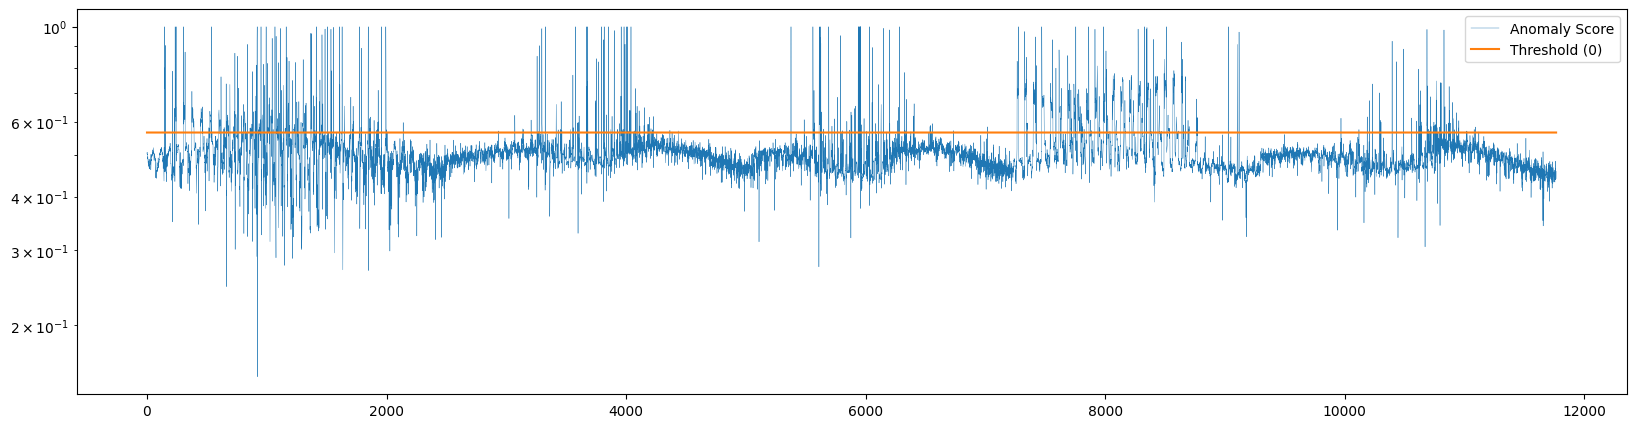

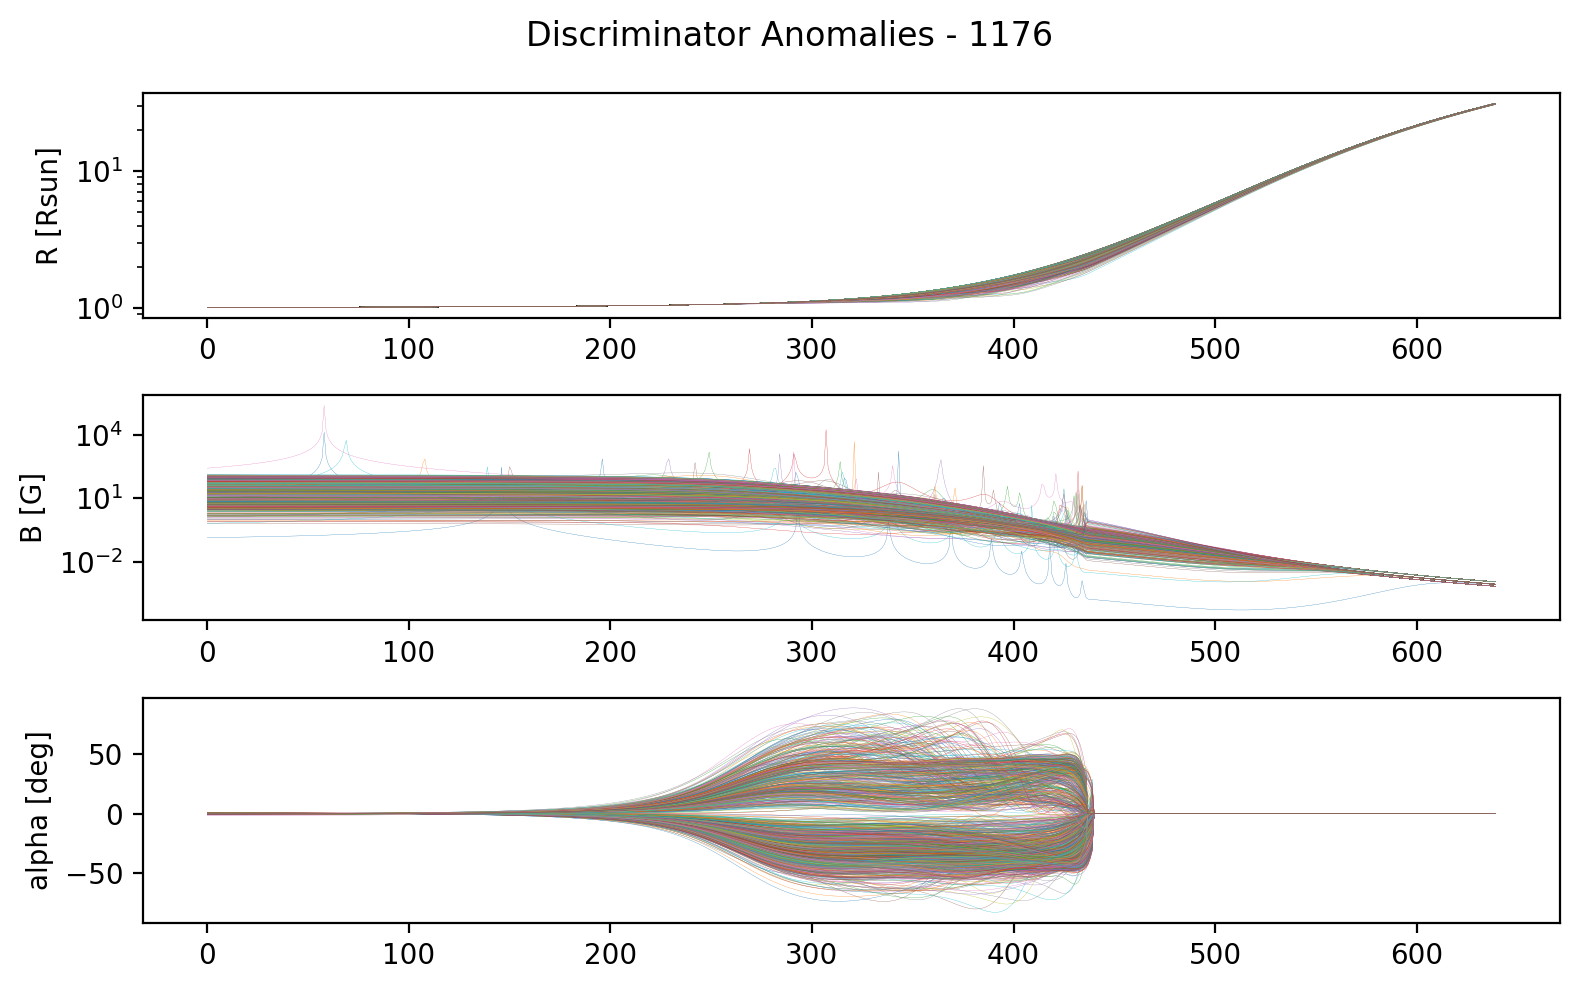

In [69]:
scores_fig, anomal_fig =\
    plot_anomaly_scores(scores, 0.1, opts.data_path, opts_eval.models_dir /  f"img/discr_scores",
                        scale="log", method="Discriminator", logger=logger, logger_var="test/discr")

## Reconstruction Based

In [58]:
def reconstruction_anomaly_scores(dataloader, netG : nn.Module, netD : nn.Module, device : str,
                                  max_iters=100, reconstr_fn=madgan_reconstruction):
    mse_scores = []
    for i, (x, filenames) in enumerate(dataloader, 0):
        _z, loss = reconstr_fn(x, netG, netD, device, max_iters)
        mse_scores.extend(zip(filenames, [l.sum(-1).detach().cpu().numpy()[0] for l in loss]))
        print(f"[{i}/{len(dataloader)}]", end='\r', flush=True)
        
    return mse_scores

### MSE Reconstruction

In [59]:
reconstr_scores = reconstruction_anomaly_scores(eval_dataloader, netG, netD, device, opts_eval.niter, madgan_reconstruction)

Anomaly Threshold:  2.0037727
Found 1176 anomalies


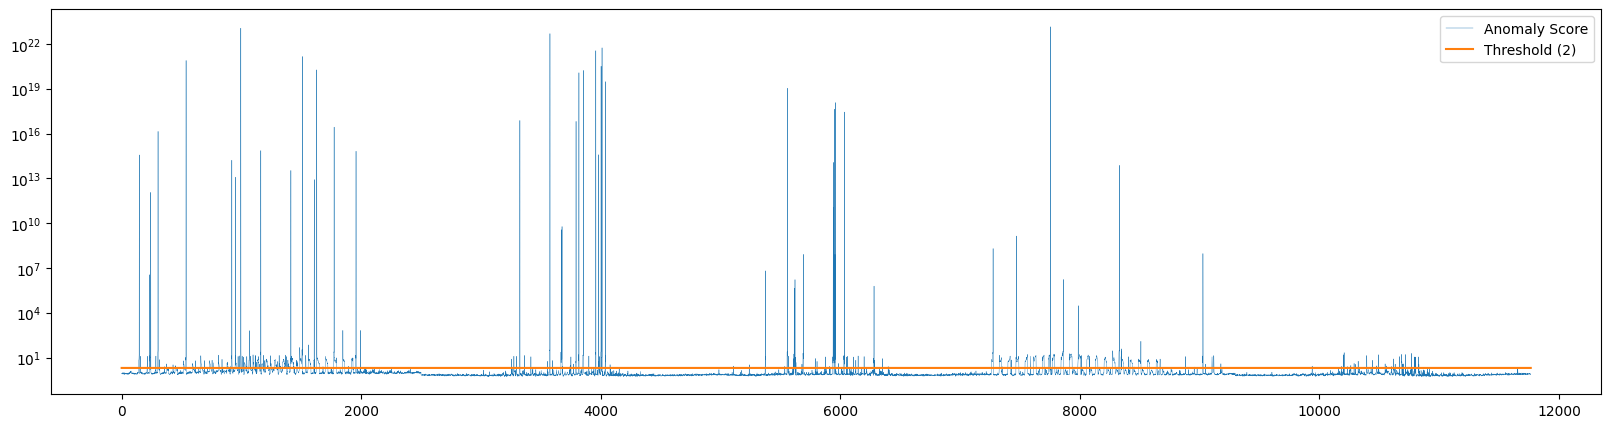

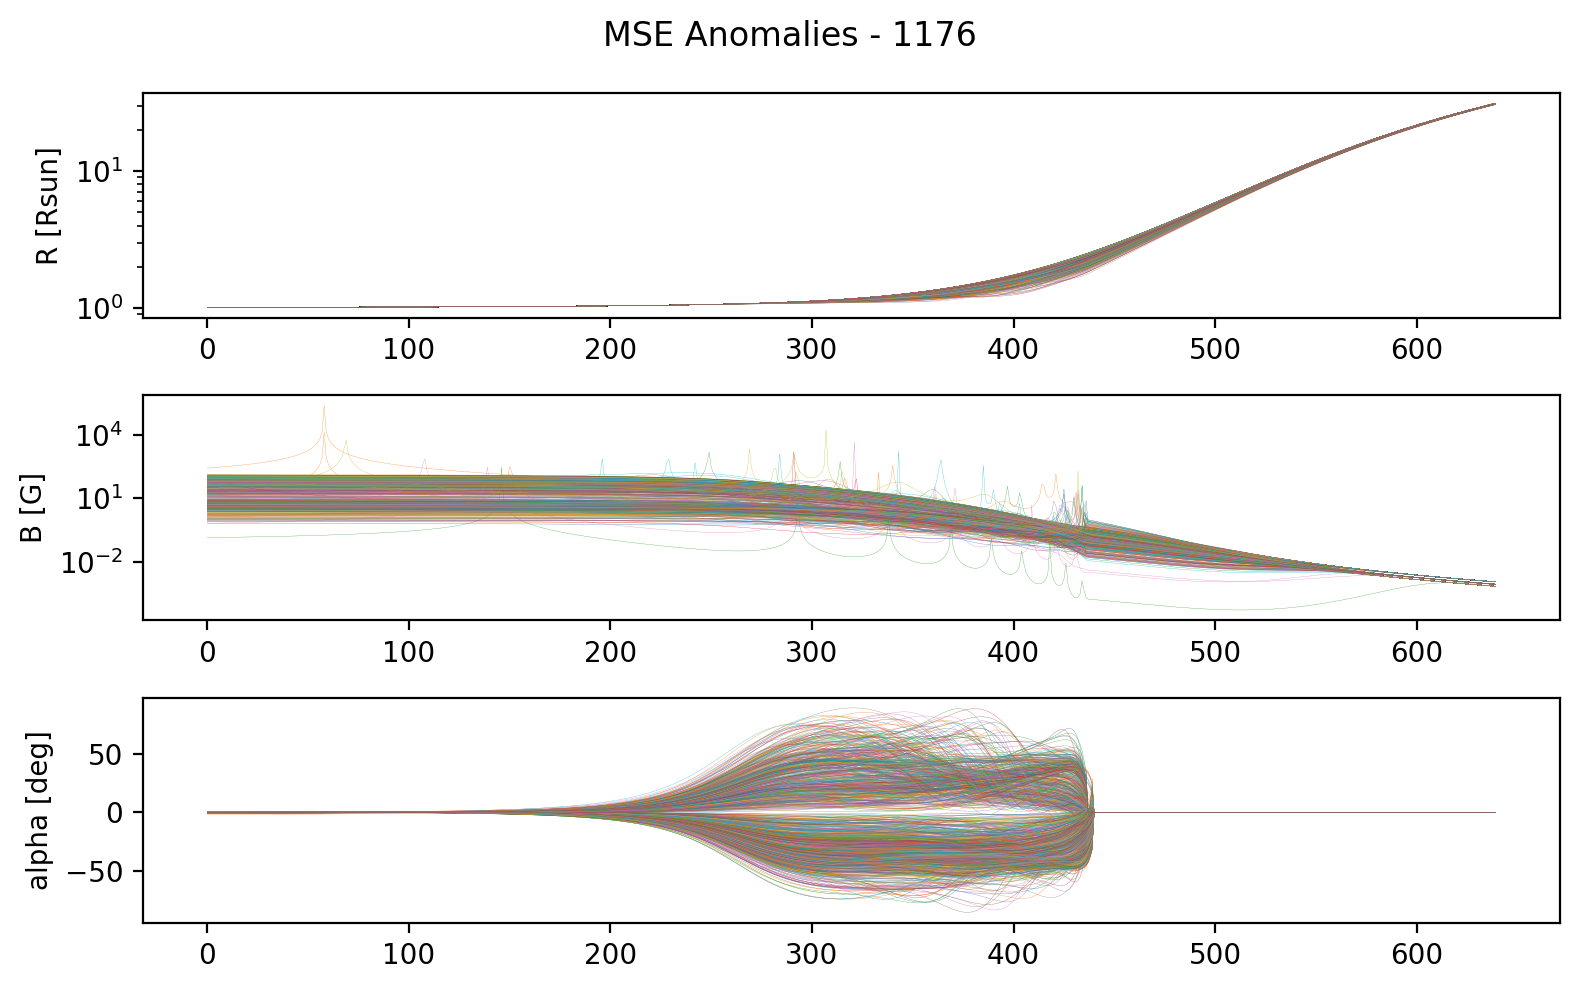

In [60]:
scores_fig, anomal_fig =\
    plot_anomaly_scores(reconstr_scores, 0.1, opts.data_path, opts_eval.models_dir /  f"img/mse", 
                        scale="log", method="MSE", logger=logger, logger_var="test/mse")

### MSE Reconstruction with Discriminator feedback

In [61]:
reconstr_scores_discr = reconstruction_anomaly_scores(eval_dataloader, netG, netD, device,
                                                      opts_eval.niter, madgan_reconstruction_discr_loss)

Anomaly Threshold:  0.70404553
Found 1176 anomalies


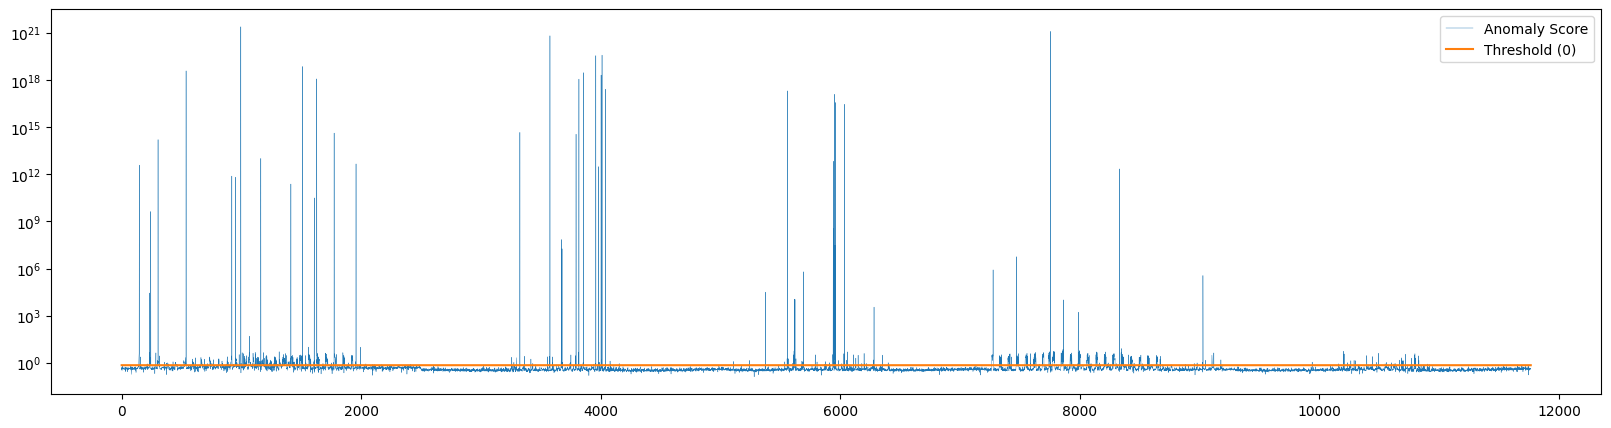

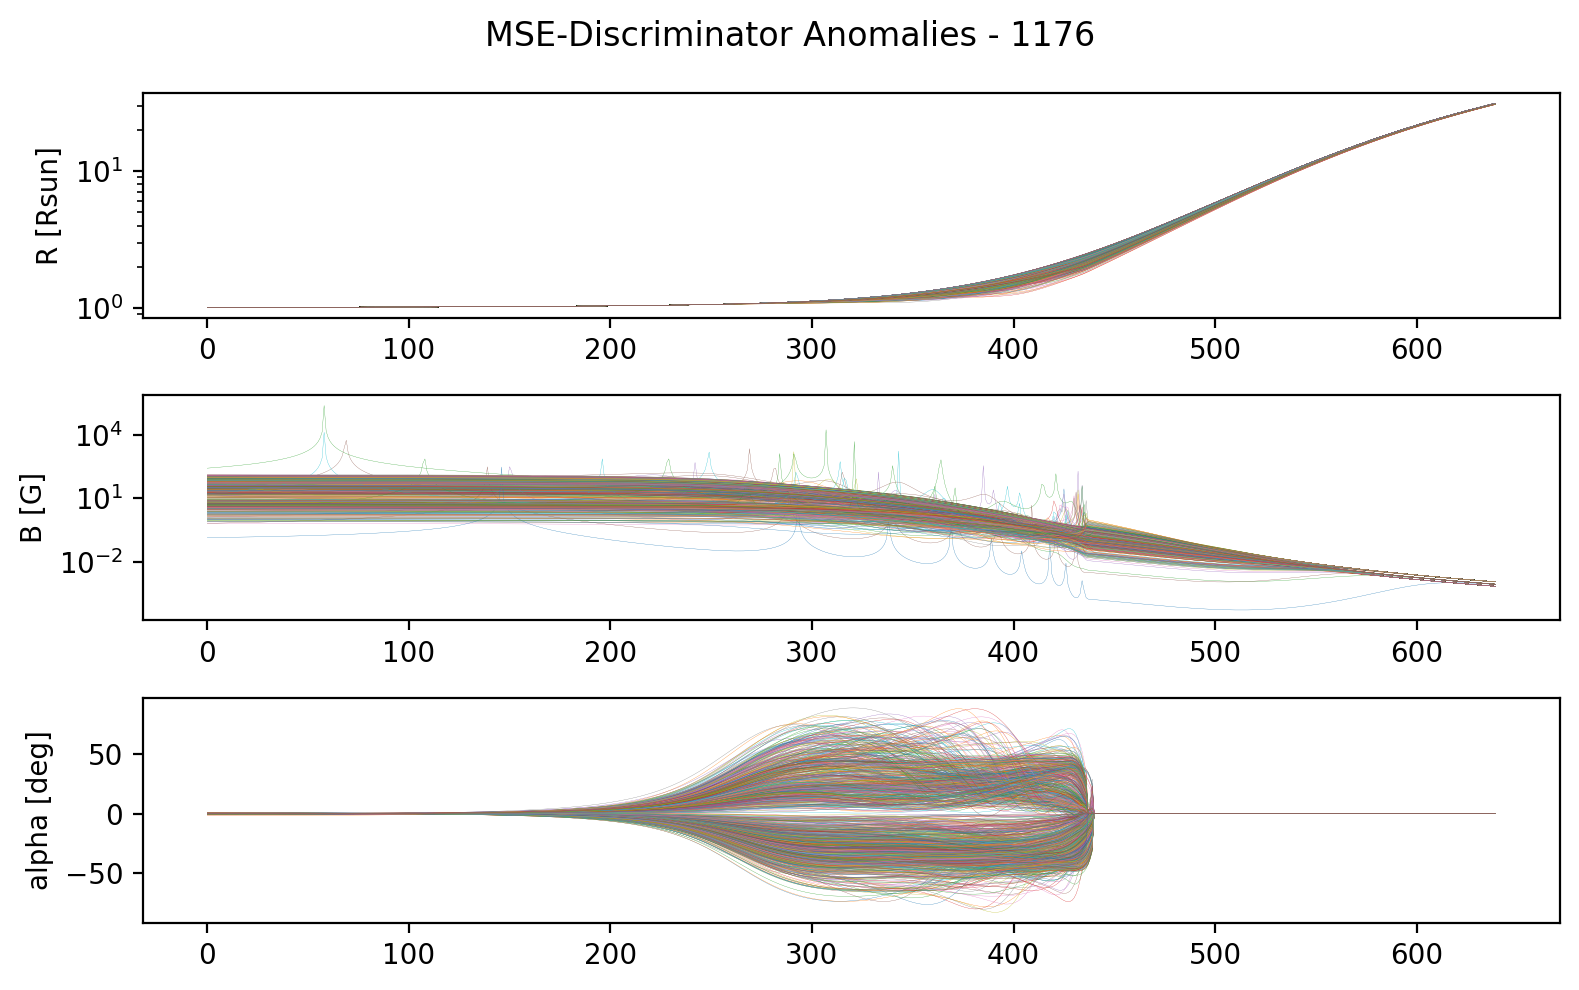

In [62]:
scores_fig, anomal_fig =\
    plot_anomaly_scores(reconstr_scores_discr, 0.1, opts.data_path, opts_eval.models_dir /  f"img/mse_discr",
                        scale="log", method="MSE-Discriminator", logger=logger, logger_var="test/mse_discr")

### Feature Reconstruction

In [63]:
reconstr_feature_scores = reconstruction_anomaly_scores(eval_dataloader, netG, netD, device,
                                                        opts_eval.niter, madgan_reconstruction_discr_loss)

Anomaly Threshold:  0.70575154
Found 1176 anomalies


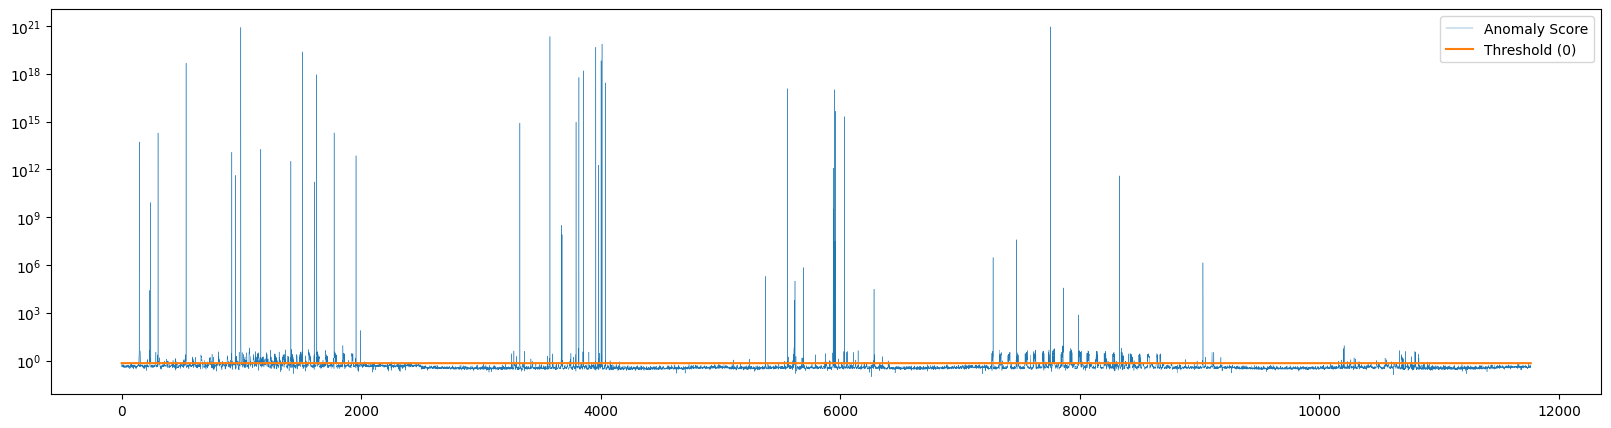

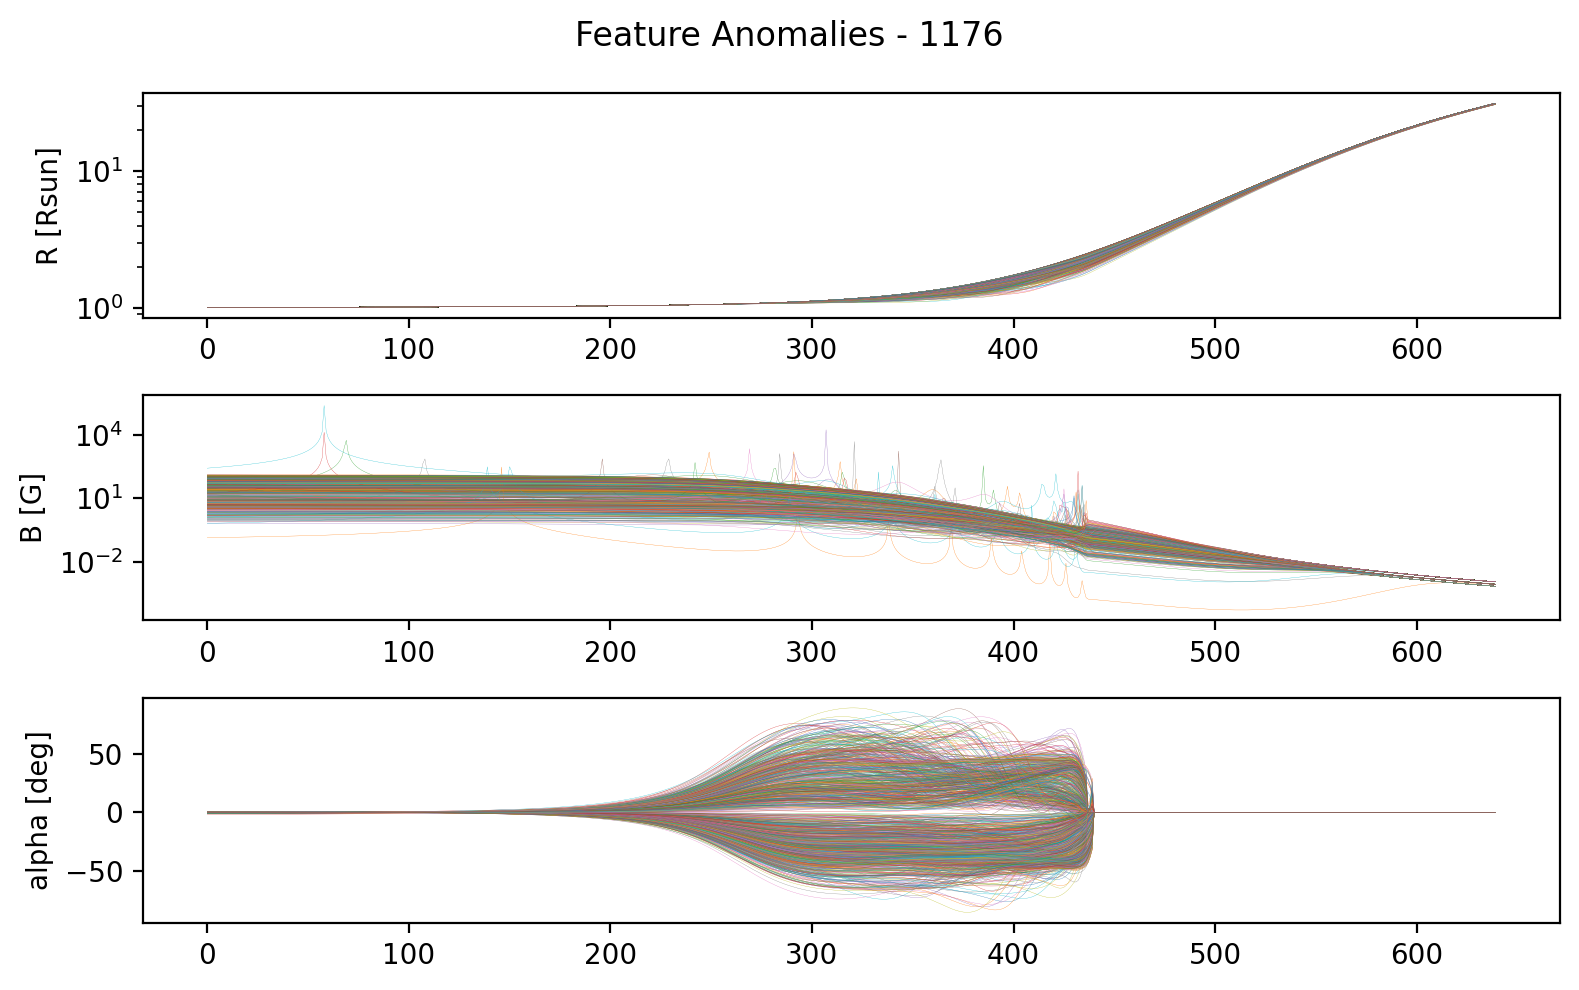

In [64]:
scores_fig, anomal_fig =\
    plot_anomaly_scores(reconstr_feature_scores, 0.1, opts.data_path, opts_eval.models_dir /  f"img/mse_feature",
                        scale="log", method="Feature", logger=logger, logger_var="test/mse_feature")

### Covariance Reconstruction

In [65]:
def madgan_reconstruction_l1(batch : torch.Tensor, netG : nn.Module, netD : nn.Module,
                          device : str, max_iter : int = 100):
    x = batch.to(device)
    z = torch.randn_like(x, requires_grad=True).to(device)
    # nn.init.normal_(z, std=0.05)
    
    optm = torch.optim.RMSprop([z], lr=0.01)
    loss_fn = nn.KLDivLoss(reduction="batchmean")
    
    # norm_x = nn.functional.normalize(x, dim=1, p=2)
    for _ in range(max_iter):
        optm.zero_grad()
        G_z = netG(z)
        # norm_z = nn.functional.normalize(G_z, dim=1, p=2)
        # loss = loss_fn(G_z, x).sum(dim=(1,2))
        loss = loss_fn(G_z, x)
        # print(loss)
        
        # if loss.mean() - previous_loss < 0.001: break # TODO
        loss.backward()
        optm.step()
        # previous_loss = loss.mean()
    
    # print(loss) 
    return z, [loss]

In [66]:
reconstr_cov_scores = reconstruction_anomaly_scores(eval_dataloader, netG, netD, device,
                                                        opts_eval.niter, madgan_reconstruction_l1)

IndexError: too many indices for array: array is 0-dimensional, but 1 were indexed

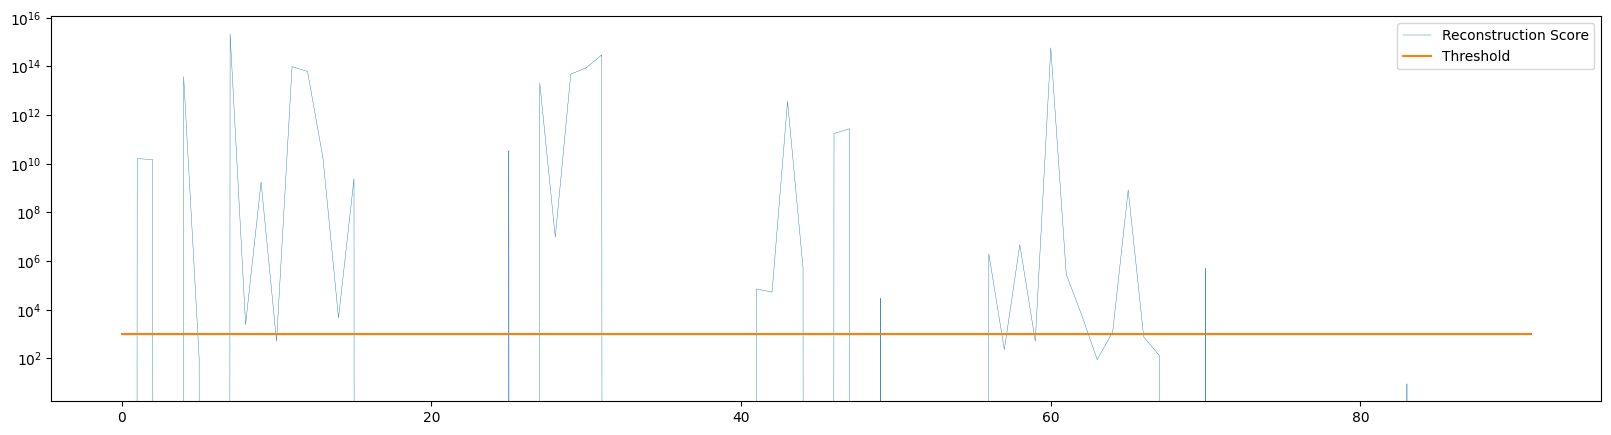

In [ ]:
reconstr_cov_thresh = 10e2
scores_fig, ax = plt.subplots(figsize=(20, 5))
ax.plot([score[1] for score in reconstr_cov_scores], label='Reconstruction Score', linewidth=0.3)
ax.plot(reconstr_cov_thresh*np.ones(len(reconstr_cov_scores)), label='Threshold')
plt.legend()
ax.set_yscale('log')
scores_fig.savefig(opts_eval.models_dir/ f"img/feature_scores", dpi=200)
_ = plot_to_tensorboard(logger, scores_fig, 0, "test/feature_scores")

Found 32 anomalies


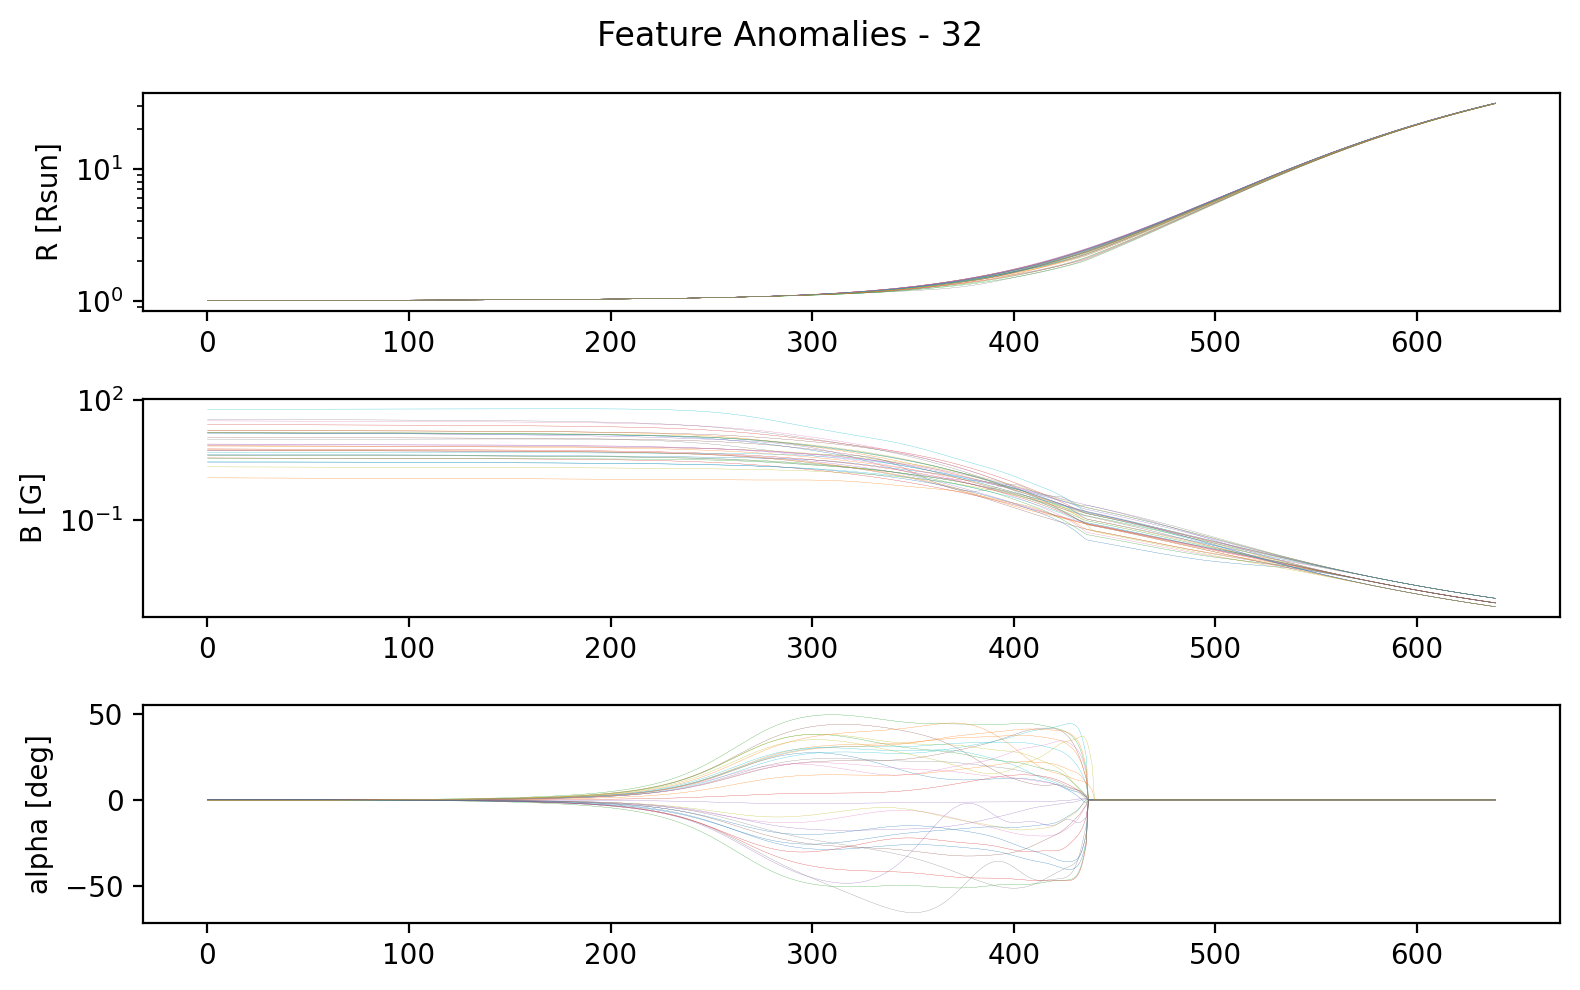

In [ ]:
anomalies = [score[0] for score in reconstr_cov_scores if score[1] > reconstr_cov_thresh]
print(f"Found {len(anomalies)} anomalies")
anomal_fig = plot_anomalies(anomalies, opts.data_path, f"Feature Anomalies - {len(anomalies)}", figsize=(8, 5), dpi=200)
anomal_fig.savefig(opts_eval.models_dir / f"img/feature_anomalies", dpi=200)
_ = plot_to_tensorboard(logger, anomal_fig, 0, "test/feature_anomalies")

In [ ]:
logger.flush()